# Predicting Profitable Customers in Banking Industry

* Import packages

In [1]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import *
from pyspark.sql.functions import stddev_pop, avg,stddev
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Matrices
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import SparkSession

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

### Reading Dataset from a csv. Data contains header also 

In [3]:

rawData = pd.read_csv("../data/credit-data.csv", header=0)

In [4]:
rawData.head(5)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,good,1,18,critical/other existing credit,used car,1049,1,2,4,male: single,...,4,2,21,3,free apartment,1,3,1,yes,yes
1,good,1,9,critical/other existing credit,other,2799,1,3,2,male: married / widowed,...,2,1,36,3,free apartment,2,3,2,yes,yes
2,good,2,12,existing paid,retraining,841,2,4,2,male: single,...,4,1,23,3,free apartment,1,2,1,yes,yes
3,good,1,12,critical/other existing credit,other,2122,1,3,3,male: married / widowed,...,2,1,39,3,free apartment,2,2,2,yes,no
4,good,1,12,critical/other existing credit,other,2171,1,3,4,male: married / widowed,...,4,2,38,1,rented flat,2,2,1,yes,no


In [5]:
rawData.shape

(1000, 21)

## Data Cleaning

* All these variables are either categorical (like Account-Balance, Previous-credit, purpose etc) or continuous (Duration-of-credit, Installment-percent, dependents).As part of data preparation for our analysis, we transformed thevalues of categorical variable’s from string to scores (numerical val-ues). For example, the variable creditability got 2 values - good and bad. After transformation process, ”good” got replaced by ”1” and”bad” got replaced by ”0”.

In [6]:

rawData['Creditability'].replace({'bad':0,'good':1},inplace=True)


In [7]:
rawData['Foreign_Worker'].replace({'no':2,'yes':1},inplace=True)

In [8]:
rawData['Telephone'].replace({'no':2,'yes':1},inplace=True)

In [9]:
def Previous_Credit_condition(value):
    if value.strip() == 'critical/other existing credit':
        return 4
    if value.strip() == 'existing paid':
        return 2
    if value.strip() == 'all paid':
        return 1
    if value.strip() == 'delayed previously':
        return 3
    if value.strip() == 'no credits/all paid':
        return 0
    

In [10]:
def Purpose_condition(value):
    if value.strip() == 'new car':
        return 1
    if value.strip() == 'used car':
        return 2
    if value.strip() == 'items of furniture':
        return 3
    if value.strip() == 'radio / television':
        return 4
    if value.strip() == 'household appliances':
        return 5
    if value.strip() == 'repair':
        return 6
    if value.strip() == 'education':
        return 7
    if value.strip() == 'vacation':
        return 8
    if value.strip() == 'retraining':
        return 9
    if value.strip() == 'business':
        return 10
    if value.strip() == 'other':
        return 0

In [11]:
def Sex_MaritalStatus_condition(value):
    if value.strip() == 'male: divorced / living apart':
        return 1
    if value.strip() == 'male: single':
        return 2
    if value.strip() == 'male: married / widowed':
        return 3
    if value.strip() == 'female:':
        return 4
    

In [12]:
def Guarantors_condition(value):
    if value.strip() == 'none':
        return 1
    if value.strip() == 'Co-Applicant':
        return 2
    if value.strip() == 'Guarantor':
        return 3

In [13]:
def Type_apartment_condition(value):
    if value.strip() == 'free apartment':
        return 1
    if value.strip() == 'rented flat':
        return 2
    if value.strip() == 'owner-occupied flat':
        return 3

In [14]:
rawData['Previous_Credit'] = rawData['Previous_Credit'].apply(Previous_Credit_condition)
rawData['Purpose'] = rawData['Purpose'].apply(Purpose_condition)
rawData['Sex_MaritalStatus'] = rawData['Sex_MaritalStatus'].apply(Sex_MaritalStatus_condition)
rawData['Guarantors'] = rawData['Guarantors'].apply(Guarantors_condition)
rawData['Type_apartment'] = rawData['Type_apartment'].apply(Type_apartment_condition)

## Cleaned Dataset

In [15]:
rawData.head(5)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [16]:
%matplotlib inline
sn.set(color_codes=True)

In [17]:

spark = SparkSession.builder.appName("analytics").master("local").getOrCreate()
csvDF = spark.createDataFrame(rawData)

In [18]:
csvPandas=rawData

In [19]:
csvPandas.head(10)

,Creditability,Account_Balance,Duration_of_Credit,Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,employment,Instalment_percent,Sex_MaritalStatus,...,Duration_address,asset,Age,Concurrent_Credits,Type_apartment,No_of_Credits,Occupation,dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
5,1,1,10,4,0,2241,1,2,1,3,...,3,1,48,3,1,2,2,2,1,2
6,1,1,8,4,0,3398,1,4,1,3,...,4,1,39,3,2,2,2,1,1,2
7,1,1,6,4,0,1361,1,2,2,3,...,4,1,40,3,2,1,2,2,1,2
8,1,4,18,4,3,1098,1,1,4,2,...,4,3,65,3,2,2,1,1,1,1
9,1,2,24,2,3,3758,3,1,1,2,...,4,4,23,3,1,1,1,1,1,1


## Exploratory analysis

* From this diagram, we understand that most of the customers requested for loans for up to 2500 German Marks. The number of customers decreases as the loan amount increases. And very few customers fall under the loan amount category over10000 German Marks

Text(0,0.5,'Frequency')

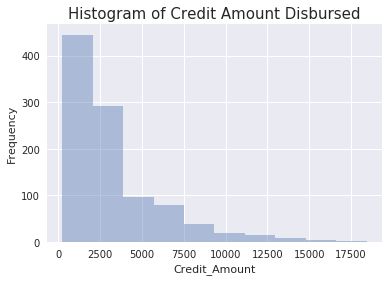

In [20]:
sn.distplot(csvPandas.Credit_Amount, kde = False,bins=10 )
plt.title( "Histogram of Credit Amount Disbursed", fontsize = 15)
plt.ylabel( "Frequency")


* Below graph shows the credit amount availed by bad customers and good customers respectively. The trend is almost same that, maximum customers from both the classes fall under the category of up to 2500 German Marks. But there is a noticeable difference in the number of customers under 12500 range. Bad rated customers are more in this category

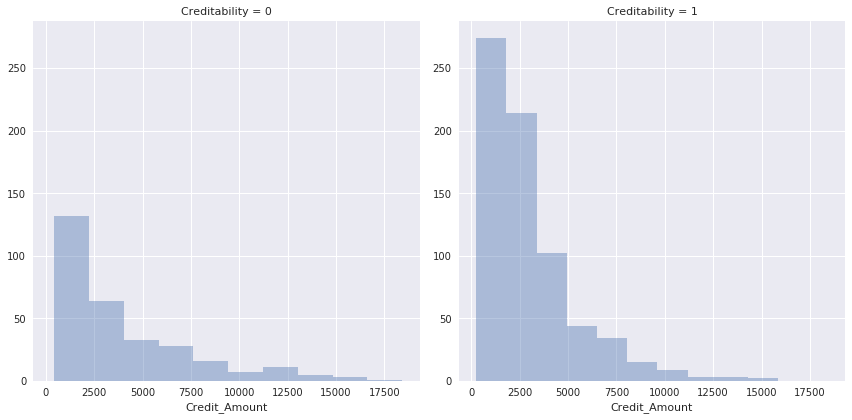

In [21]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Credit_Amount", kde = False, bins = 10 )

* Below graph shows the duration of credit in months vs. number ofcustomers. From this graph, we can understand that maximum number of customers opted for 10 to 15 months duration

Text(0,0.5,'Frequency')

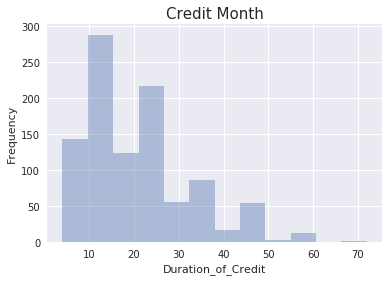

In [22]:
sn.distplot(csvPandas.Duration_of_Credit, kde = False,bins=12)
plt.title( "Credit Month", fontsize = 15)
plt.ylabel( "Frequency")

*  Below graph shows the duration of credit in monthsvs number of customer bad customers and good customers respec-tively. It shows that there is not much difference in the trend

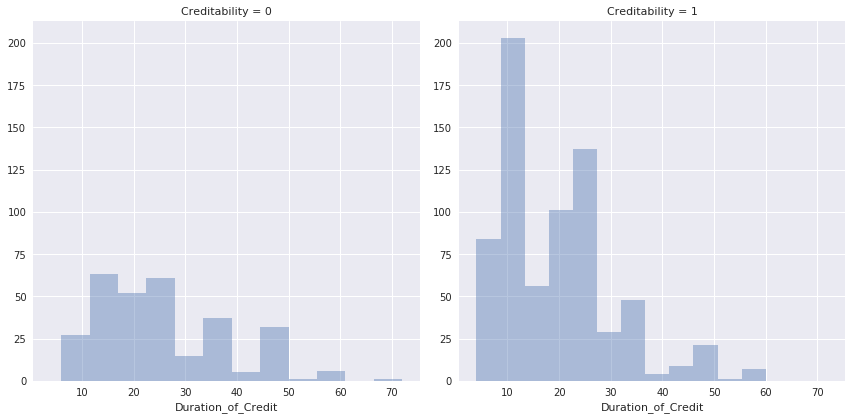

In [23]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Duration_of_Credit", kde = False, bins = 12)

* Graph shows how customers are scattered with respect toage. Most of the borrowers fall under the age group of 23 to 28

Text(0,0.5,'Frequency')

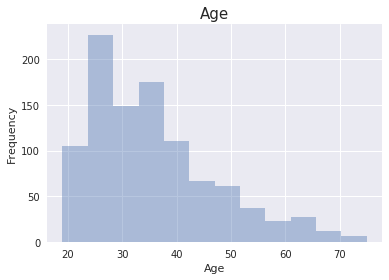

In [24]:
sn.distplot(csvPandas.Age, kde = False,bins=12)
plt.title( "Age", fontsize = 15)
plt.ylabel( "Frequency")

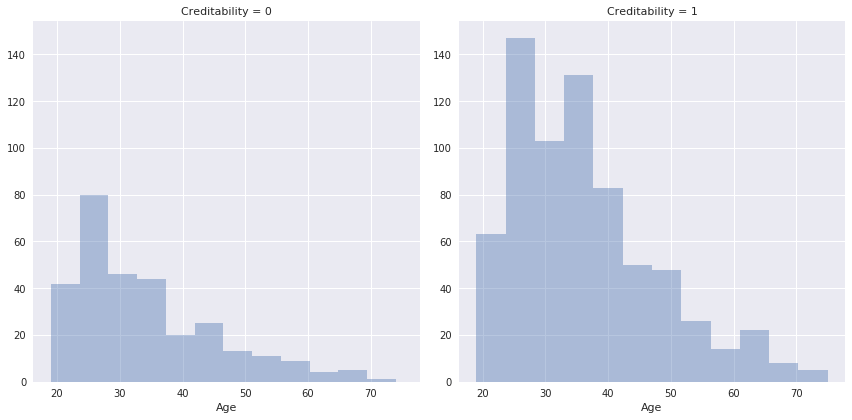

In [25]:
g = sn.FacetGrid(csvPandas, col="Creditability", size = 6)
g.map(sn.distplot, "Age", kde = False, bins = 12)

* Customers in our dataset are classiffied into 2 classes - Good(1 = Creditworthy) and Bad (0 = Uncreditworthy). We have 700customers in the Good class and 300 customers in the Bad class

In [26]:
csvDF.select("Creditability").groupBy("Creditability").count().show()

+-------------+-----+
|Creditability|count|
+-------------+-----+
|            0|  300|
|            1|  700|
+-------------+-----+



### Interquartile Range

* Interquartile Range is a statistical method to measure the vari-ability of the data. This will be applicable only for the continuousvariables (Credit-amount, Duration of credit and Age). The rank-ordered data will be divided into 4 equal parts called quartiles.Values are called the First (Q1) Second (Q2) and Third (Q3) quartiles.Q2 is the Median value of the dataset

In [27]:
rows=[]
rows.append((csvPandas['Credit_Amount'].min(),csvPandas.Credit_Amount.quantile(.25),csvPandas['Credit_Amount'].median(),csvPandas['Credit_Amount'].mean(),csvPandas.Credit_Amount.quantile(.75),csvPandas['Credit_Amount'].max()))
crAmountPerc = pd.DataFrame(rows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
crAmountPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,250,1365.5,2319.5,3271.248,3972.25,18424


In [28]:
dcrows=[]
dcrows.append((csvPandas['Duration_of_Credit'].min(),csvPandas.Duration_of_Credit.quantile(.25),csvPandas['Duration_of_Credit'].median(),csvPandas['Duration_of_Credit'].mean(),csvPandas.Duration_of_Credit.quantile(.75),csvPandas['Duration_of_Credit'].max()))
dcPerc = pd.DataFrame(dcrows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
dcPerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,4,12.0,18.0,20.903,24.0,72


In [29]:
Agerows=[]
Agerows.append((csvPandas['Age'].min(),csvPandas.Age.quantile(.25),csvPandas['Age'].median(),csvPandas['Age'].mean(),csvPandas.Age.quantile(.75),csvPandas['Age'].max()))
agePerc = pd.DataFrame(Agerows,columns=["Min","1st Qu","Median","Mean","3rd Qu","Max"])
agePerc.head()

,Min,1st Qu,Median,Mean,3rd Qu,Max
0,19,27.0,33.0,35.542,42.0,75


### Pearson’s Chi-squared test

* Chi-squared test is used to determine the significant difference between expected values and observed values in one or more cate-gories

In [30]:
data=csvDF.rdd.map(lambda x:(Vectors.dense(x[1:]), float(x[0]))).toDF(["features", "label"])

In [31]:
r = ChiSquareTest.test(data, "features", "label").head()

In [32]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'PValues':r.pValues.values,'Chi^2':r.statistics.values,'D.F':r.degreesOfFreedom})
pdf.head(21)

,All,Chi^2,D.F,PValues
0,Account_Balance,123.720944,3,0.000000e+00
1,Duration_of_Credit,78.886937,32,7.784572e-06
2,Previous_Credit,61.691397,4,1.279199e-12
3,Purpose,33.356447,9,1.157491e-04
4,Credit_Amount,931.746032,922,4.045155e-01
5,Value_Savings_Stocks,36.098928,4,2.761214e-07
6,employment,18.368274,4,1.045452e-03
7,Instalment_percent,5.476792,3,1.400333e-01
8,Sex_MaritalStatus,9.605214,3,2.223801e-02
9,Guarantors,6.645367,2,3.605595e-02


In [33]:
dataPanda = data.toPandas()
dataPanda.head(5)

,features,label
0,"[1.0, 18.0, 4.0, 2.0, 1049.0, 1.0, 2.0, 4.0, 2...",1.0
1,"[1.0, 9.0, 4.0, 0.0, 2799.0, 1.0, 3.0, 2.0, 3....",1.0
2,"[2.0, 12.0, 2.0, 9.0, 841.0, 2.0, 4.0, 2.0, 2....",1.0
3,"[1.0, 12.0, 4.0, 0.0, 2122.0, 1.0, 3.0, 3.0, 3...",1.0
4,"[1.0, 12.0, 4.0, 0.0, 2171.0, 1.0, 3.0, 4.0, 3...",1.0


In [34]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Logistic Regression

In [35]:
lrEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [36]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lrModel = lr.fit(trainingData)
lrPredictions = lrModel.transform(testData)
lrEvaluator.evaluate(lrPredictions)

0.7892976588628763

In [37]:
lrMetricsData = lrPredictions.select("label","prediction")
pandaLrMetrics=lrMetricsData.groupby("label","prediction").count().toPandas()
pivotedLr = pandaLrMetrics.pivot(index='label', columns='prediction', values='count')
pivotedLr.head(5)

prediction,0.0,1.0
label,,
0.0,45,48
1.0,15,191


In [38]:
lrModel.coefficients

DenseVector([0.5384, -0.0253, 0.2658, 0.0009, -0.0001, 0.1568, 0.1478, -0.3727, 0.1268, 0.093, -0.0769, -0.2446, 0.0162, 0.0211, 0.1021, -0.1559, -0.072, -0.5042, 0.1779, -0.391])

In [39]:
print ('Model Intercept: ', lrModel.intercept)

Model Intercept:  0.7989439851104996


# Decision Tree

* We created 2 Decision Tree models to compare the accuracy.Decision Tree with maxDepth None:In this model, we set themaxDepth value of the Tree to None and we calculated the accuracy using PySpark’s ”MulticlassClassifficationEvaluator”. In this case,the tree can become arbitrarily deep and complex and more chancesof over fitting issues. The accuracy of the output of this model is 0.679 Maximumnumber of Bins are 32 Depth is None.  Decision Tree after adjusting the attribute values:In this model,we set the maxDepth value to 6 and maxBins value to 20. We usedthe same PySpark’s ”MulticlassClassifficationEvaluator” to calculatethe accuracy. Since we have limited the maxDepth and maxBinvalues, the over fitrting issues decreases. The accuracy of the output of this model is 0.716 Number of Binsare 20 Depth is 6

In [40]:
dtEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

### Decision Tree with maxDepth None 

In [41]:
dt1 = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=None)
dtModel1=dt1.fit(trainingData)
dtPredictions1=dtModel1.transform(testData)
dtEvaluator.evaluate(dtPredictions1)

0.6889632107023411

In [42]:
print("Bins :",dt1.getMaxBins())
print("Depth :",dt1.getMaxDepth())

Bins : 32
Depth : None


### Decision Tree after adjusting the attribute values

In [43]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=6,maxBins=20)

In [44]:
dtModel=dt.fit(trainingData)
dtPredictions=dtModel.transform(testData)
dtEvaluator.evaluate(dtPredictions)

0.7157190635451505

In [45]:
print("Bins :",dt.getMaxBins())
print("Depth :",dt.getMaxDepth())

Bins : 20
Depth : 6


In [46]:
dtPredictionsPanda = dtPredictions.toPandas()
dtPredictionsPanda.head(5)

,features,label,rawPrediction,probability,prediction
0,"[1.0, 6.0, 1.0, 6.0, 1198.0, 1.0, 5.0, 4.0, 2....",0.0,"[1.0, 3.0]","[0.25, 0.75]",1.0
1,"[1.0, 6.0, 2.0, 0.0, 662.0, 1.0, 2.0, 3.0, 3.0...",1.0,"[0.0, 27.0]","[0.0, 1.0]",1.0
2,"[1.0, 6.0, 2.0, 3.0, 2647.0, 3.0, 3.0, 2.0, 3....",1.0,"[0.0, 27.0]","[0.0, 1.0]",1.0
3,"[1.0, 6.0, 4.0, 2.0, 3384.0, 1.0, 3.0, 1.0, 1....",0.0,"[0.0, 27.0]","[0.0, 1.0]",1.0
4,"[1.0, 8.0, 4.0, 10.0, 1164.0, 1.0, 5.0, 3.0, 3...",1.0,"[2.0, 14.0]","[0.125, 0.875]",1.0


### Prediction Matrix

* 0.0 -> Bad

 * 1.0 -> Good

In [47]:
dtMetricsData = dtPredictions.select("label","prediction")
pandaDtMetrics=dtMetricsData.groupby("label","prediction").count().toPandas()
pivotedDt = pandaDtMetrics.pivot(index='label', columns='prediction', values='count')
pivotedDt.head(5)

prediction,0.0,1.0
label,,
0.0,37,56
1.0,29,177


In [48]:
dtPenalty=pivotedDt.values[0][1]*5+pivotedDt.values[1][0]
print("Penalty of the matrix",dtPenalty)

Penalty of the matrix 309


# Random Forest

### Random Forest with Default Settings 

In [49]:
dfEvaluator1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [50]:
rf1 = RandomForestClassifier(labelCol="label", featuresCol="features")
rfModel1 = rf1.fit(trainingData)
rfPredictions= rfModel1.transform(testData)

In [51]:
print("number of Classes :"+str(rfModel1.numClasses))

number of Classes :2


In [52]:
print("number of Features :"+str(rfModel1.numFeatures))

number of Features :20


In [53]:
print("Total number of Nodes :"+str(rfModel1.totalNumNodes))

Total number of Nodes :1002


In [54]:
print ("Max Bins",rf1.getMaxBins())

print ("Max Trees",rf1.getNumTrees())
print ("Max Depth",rf1.getMaxDepth())

Max Bins 32
Max Trees 20
Max Depth 5


In [55]:
dfEvaluator1.evaluate(rfPredictions)

0.7491638795986622

### Tuning Random Forest with cross-validator

* In this case, we tunethe Random Forest model by trying different attribute values fortree attributes - maxDepth, maxBin and numTrees. We can pro-vide multiple values for each attribute. We provided 3 values formaxDepth, 2 values for maxBins and 3 values for numTrees. Wewill start with some random values for these attributes.We usecross-validationtechniques in this type of Random Forestmodel to get the best model. PySpark ”CrossValidator” will analyzethe values of the attributes. In this scenario, the ”CrossValidator”will choose 3 values of attributes from 3*2*3 values. It will then try different combinations of the attribute values internally and finally,the model will get tuned to a final set of attributes which derive thebest model with maximum accuracy. The accuracy of the output of this model is 0.779 

In [56]:
rfEvaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [57]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [58]:
paramGridRf = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [10, 20])
             .addGrid(rf.numTrees, [10,20,100])
             .build())

In [59]:
rfCv = CrossValidator(estimator=rf, estimatorParamMaps=paramGridRf, evaluator=rfEvaluator, numFolds=2)

In [60]:
rfCvModel = rfCv.fit(trainingData)

In [61]:
rfPredictions = rfCvModel.transform(testData)

In [62]:
rfEvaluator.evaluate(rfPredictions)


0.7357859531772575

In [64]:


print("Max Trees",rfCvModel.bestModel.getNumTrees)


Max Trees 10


In [65]:
bestModel = rfCvModel.bestModel
finalPredictions = bestModel.transform(data)
rfEvaluator.evaluate(finalPredictions)

0.815

In [66]:
rfPredictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[1.0,6.0,1.0,6.0,...|  0.0|[4.87227898603610...|[0.48722789860361...|       1.0|
|[1.0,6.0,2.0,0.0,...|  1.0|[2.13275917157549...|[0.21327591715754...|       1.0|
|[1.0,6.0,2.0,3.0,...|  1.0|[1.36580000401650...|[0.13658000040165...|       1.0|
|[1.0,6.0,4.0,2.0,...|  0.0|[1.67182535195196...|[0.16718253519519...|       1.0|
|[1.0,8.0,4.0,10.0...|  1.0|[4.45469429150970...|[0.44546942915097...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [67]:
metricsData = rfPredictions.select("label","prediction")
sDF=metricsData.groupby("label","prediction").count()
pandaSDF=sDF.toPandas()
df2 = pandaSDF.pivot(index='label', columns='prediction', values='count')
df2.head(5)

prediction,0.0,1.0
label,,
0.0,24,69
1.0,10,196


In [68]:
penalty=df2.values[0][1]*5+df2.values[1][0]
print(penalty)

355


### Feature Importance for Random Forest

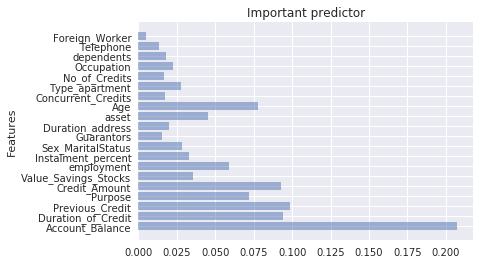

In [69]:
pdf=pd.DataFrame({'All':csvDF.columns[1:],'Important':bestModel.featureImportances.values},columns=['All','Important'])
objects = csvDF.columns[1:]
y_pos = np.arange(len(csvDF.columns[1:]))
performance = bestModel.featureImportances.values
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.ylabel('Features')
plt.title('Important predictor')

plt.show()


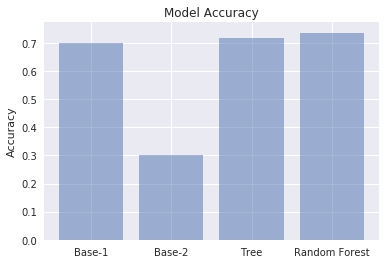

In [70]:
objects = ('Base-1', 'Base-2', 'Tree', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [.7,.3,dtEvaluator.evaluate(dtPredictions),rfEvaluator.evaluate(rfPredictions)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
 
plt.show()

## Results

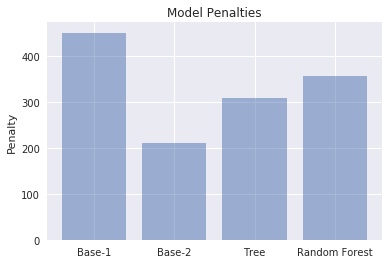

In [71]:
objects = ('Base-1', 'Base-2', 'Tree', 'Random Forest')
y_pos = np.arange(len(objects))
performance = [450,210,dtPenalty,penalty]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Penalty')
plt.title('Model Penalties')
 
plt.show()

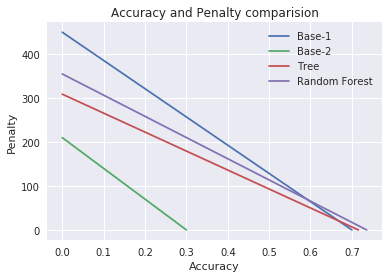

In [72]:

datax1=[.7,.3,dtEvaluator.evaluate(dtPredictions),rfEvaluator.evaluate(rfPredictions)]
datay1=[0,0,0,0]

datax2=[0,0,0,0]
datay2=[450,210,dtPenalty,penalty]
models =['Base-1','Base-2','Tree','Random Forest']

fig,ax = plt.subplots()
for i in range(len(datax1)):
    x = (datax1[i], datax2[i])
    y = (datay1[i], datay2[i]) 
    ax.plot(x, y,label=models[i])
ax.legend()
plt.title("Accuracy and Penalty comparision")
plt.xlabel("Accuracy")
plt.ylabel("Penalty")
plt.show()

